<a href="https://colab.research.google.com/github/randreove/TS/blob/exercises/notebooks/60_Forecasting%20II%20Deep%20Learning/3_Model%20Evaluation/A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Evaluation

In [1]:
!git clone https://github.com/randreove/TS.git

Cloning into 'TS'...
remote: Enumerating objects: 373, done.
remote: Counting objects: 100% (373/373), done.
remote: Compressing objects: 100% (287/287), done.
remote: Total 373 (delta 105), reused 320 (delta 62), pack-reused 0 (from 0)
Receiving objects: 100% (373/373), 27.18 MiB | 12.04 MiB/s, done.
Resolving deltas: 100% (105/105), done.
Filtering content: 100% (17/17), 142.02 MiB | 31.06 MiB/s, done.


## Load Dataset

In [2]:
import pandas as pd

df = pd.read_csv('/content/TS/notebooks/60_Forecasting II Deep Learning/data/precio_mercado_diario.csv', parse_dates=['datetime_utc'], index_col=0)
df = df.loc["2020":].copy()
df

,Mercado SPOT
datetime_utc,
2020-01-01 00:00:00+00:00,38.60
2020-01-01 01:00:00+00:00,36.55
2020-01-01 02:00:00+00:00,32.32
2020-01-01 03:00:00+00:00,30.85
2020-01-01 04:00:00+00:00,30.14
...,...
2023-08-04 17:00:00+00:00,70.00
2023-08-04 18:00:00+00:00,86.30
2023-08-04 19:00:00+00:00,94.00


## Data Preprocessing

In [3]:
data_array = df.values

In [4]:

from sklearn.model_selection import train_test_split

train, test = train_test_split(data_array, test_size=0.2, shuffle=False)

In [5]:
import numpy as np

def create_sequences(data, seq_len):
  Xs, ys = [], []

  for i in range(len(data) - seq_len):
    X = data[i:seq_len+i]
    Xs.append(X)

    y = data[seq_len+i]
    ys.append(y)

  Xs = np.array(Xs)
  ys = np.array(ys)

  return Xs, ys

X_test, y_test = create_sequences(test, seq_len=24)
X_train, y_train = create_sequences(train, seq_len=24)

## Modelling

### Design NN Architecture

In [6]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input

model = Sequential(layers=[
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(50),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

### Train Model

In [7]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=3)
history = model.fit(
    X_train, y_train, epochs=50, batch_size=64, verbose=0,
    validation_data=(X_test, y_test), callbacks=[early_stop])

### Calculate Predictions

In [8]:
y_pred = model.predict(X_test)
y_pred

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


array([[120.791756],
       [ 99.07695 ],
       [ 83.568214],
       ...,
       [ 98.34228 ],
       [ 95.4168  ],
       [ 92.22859 ]], dtype=float32)

## Comparison: Real Data & Prediction

### Create DataFrame

In [10]:
!pip install utils

  Preparing metadata (setup.py) ... done
  Created wheel for utils: filename=utils-1.0.2-py2.py3-none-any.whl size=13906 sha256=21a6f7c3b233bec75e74c94fb8f07461c0ea67c57a8a261753971cd3ca3e329b
  Stored in directory: /root/.cache/pip/wheels/b8/39/f5/9d0ca31dba85773ececf0a7f5469f18810e1c8a8ed9da28ca7
Successfully built utils


In [11]:
import utils

In [12]:
dic_pred = {
    'y_pred': y_pred
}

In [24]:
import pandas as pd

def process_df_pred(df, y_true, dic_pred):
    """
    Toma un DataFrame original con un índice de fechas más amplio, los valores reales de y_test
    y un diccionario de predicciones. Devuelve un DataFrame con el índice de fechas correspondiente
    a los valores de y_true y las predicciones.

    Parámetros:
    - df: DataFrame original con un índice de fechas.
    - y_true: Serie o array de valores reales (y_test).
    - dic_pred: Diccionario con predicciones, donde la clave es el nombre del modelo y el valor es la Serie o array de predicciones.

    Retorna:
    - DataFrame con el índice de fechas y columnas de valores reales y predicciones.
    """
    # Asegurarse de que y_true sea 1D
    if len(y_true.shape) > 1:
        y_true = y_true.ravel()

    # Asegurar que cada predicción en dic_pred sea 1D
    for model_name in dic_pred:
        if len(dic_pred[model_name].shape) > 1:
            dic_pred[model_name] = dic_pred[model_name].ravel()

    # Suponemos que y_true y dic_pred tienen un índice que coincide con una parte del índice de df
    common_index = df.index[-len(y_true):]  # Toma las últimas posiciones para que coincidan con y_true

    # Crear un DataFrame base con el índice común y y_true
    df_result = pd.DataFrame(index=common_index, data={'y_true': y_true})

    # Añadir las predicciones al DataFrame
    for model_name, pred in dic_pred.items():
        df_result[model_name] = pred

    return df_result

# Ejemplo de uso:
# resultado = process_df_pred(df, y_test, dic_pred)


In [23]:
y_pred

array([[120.791756],
       [ 99.07695 ],
       [ 83.568214],
       ...,
       [ 98.34228 ],
       [ 95.4168  ],
       [ 92.22859 ]], dtype=float32)

In [25]:
df_pred = process_df_pred(df, y_true=y_test, dic_pred=dic_pred)

# df_pred = y_test.copy()
df_pred

,y_true,y_pred
datetime_utc,,
2022-11-15 22:00:00+00:00,105.00,120.791756
2022-11-15 23:00:00+00:00,90.52,99.076950
2022-11-16 00:00:00+00:00,87.00,83.568214
2022-11-16 01:00:00+00:00,85.00,80.711655
2022-11-16 02:00:00+00:00,84.92,82.414314
...,...,...
2023-08-04 17:00:00+00:00,70.00,61.712349
2023-08-04 18:00:00+00:00,86.30,86.678741
2023-08-04 19:00:00+00:00,94.00,98.342278


### Visualize Data

#### All Hours

In [29]:
import matplotlib.pyplot as plt

def plot_predictions(df_pred):
    """
    Genera una gráfica de los valores reales y las predicciones.

    Parámetros:
    - df_pred: DataFrame que contiene la columna 'y_true' con los valores reales y
               otras columnas con las predicciones de distintos modelos.
    """
    plt.figure(figsize=(14, 7))

    # Graficar la columna de valores reales
    plt.plot(df_pred.index, df_pred['y_true'], label='Valores Reales (y_test)', linewidth=2, color='red')

    # Graficar cada columna de predicciones
    for col in df_pred.columns:
        if col != 'y_true':
            plt.plot(df_pred.index, df_pred[col], label=f'Predicción: {col}')

    plt.title('Comparación de Valores Reales y Predicciones')
    plt.xlabel('Fecha')
    plt.ylabel('Valores')
    plt.legend()
    plt.grid(True)
    plt.show()

# Ejemplo de uso:
# plot_predictions(df_pred)


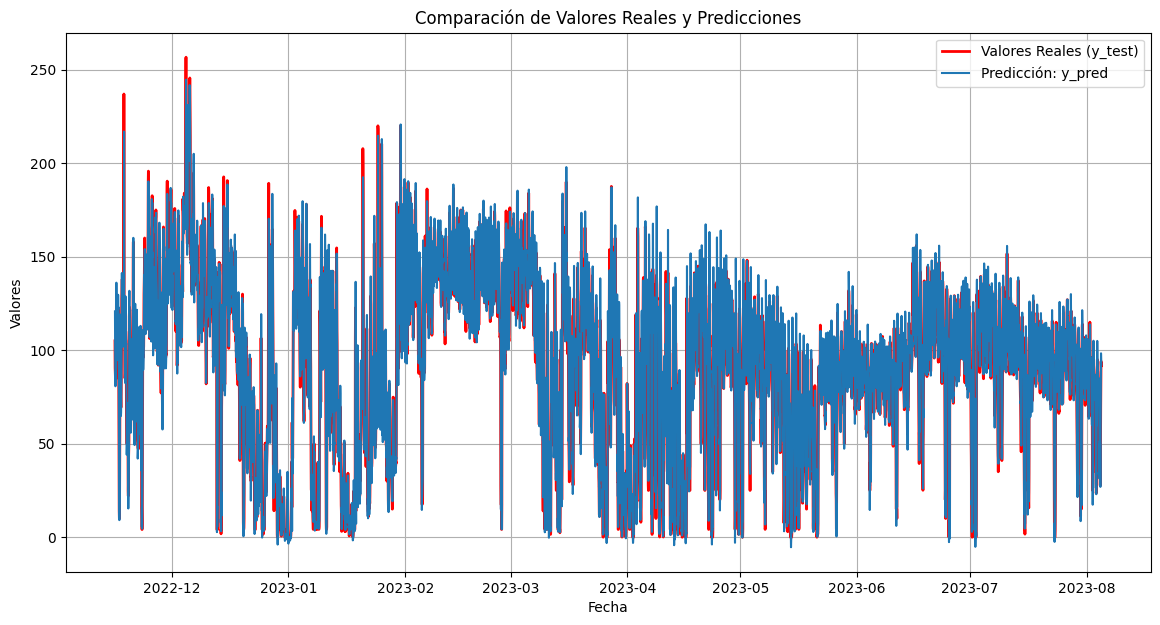

In [30]:
plot_predictions(df_pred)

#### Last 2 Days

In [33]:
dff = df_pred.loc['2023-08-01':]

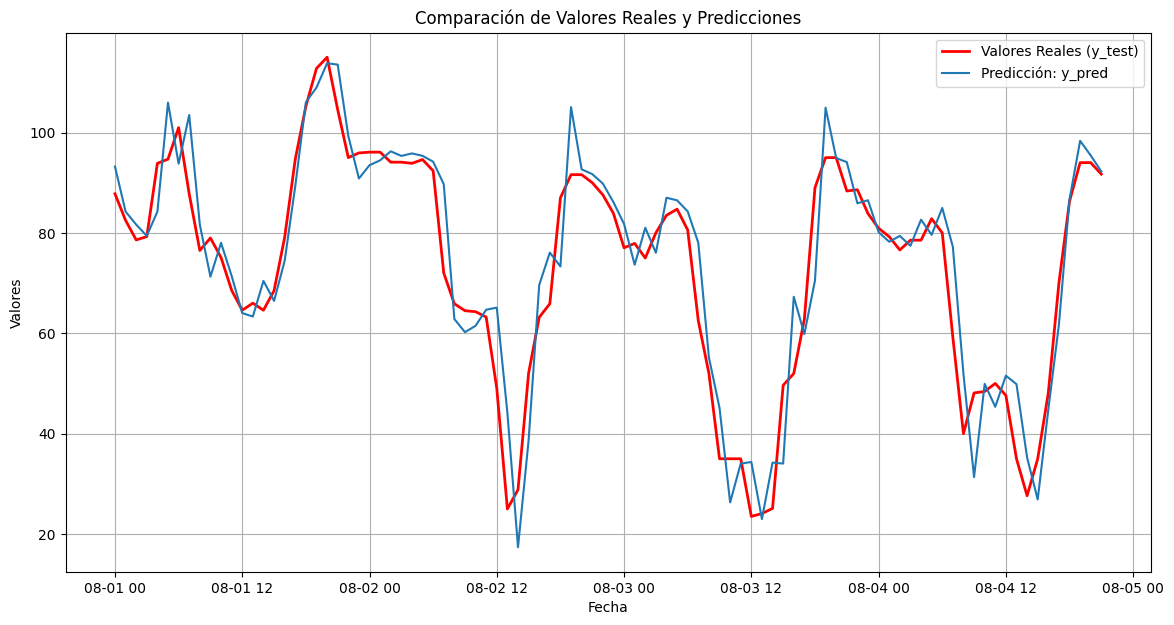

In [34]:
plot_predictions(dff)

## Metrics to Measure Model Error

### Mean Squared Error

In [35]:
df_pred['error'] = df_pred.y_pred - df_pred.y_true

In [37]:
df_pred['error2'] = df_pred.error**2

In [43]:
MSE = df_pred.error2.mean()

In [46]:
MSE

121.62697256200073

### Mean Absolute Error

In [38]:
df_pred['error_abs'] = df_pred.error.abs()

In [47]:
MAE = df_pred.error_abs.mean()

In [48]:
MAE

7.338095209330093

### Root Mean Squared Error

In [41]:
import numpy as np

In [44]:
RMSE = np.sqrt(MSE)

In [45]:
RMSE

11.028461930931291

### Scikit-Learn Metrics

/Users/sota/miniconda3/envs/work/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



7.371508163532227

126.77113485183527

11.259268841795867